In [1]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "seaborn"

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle

import sys
sys.path.append("..")
from pygalaxy import Euler_symplectic_tree, ADB6
from pygalaxy import init_solar_system
from pygalaxy.barnes_hut_array import compute_energy_and_tree_structure
#from pygalaxy.naive import compute_energy

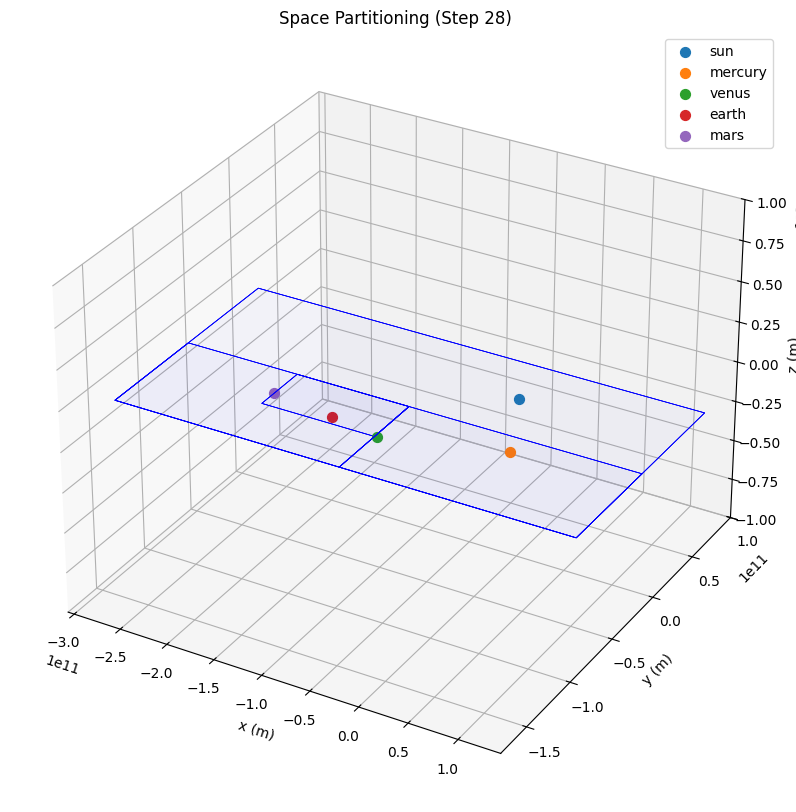

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Simulation parameters
dt = 86400  # 1 day in seconds
nt = 30  # Number of time steps
dim = 3  # Number of dimensions

# Initialize solar system
mass, particles, planets = init_solar_system(dim)

# Number of bodies
nbodies = particles.shape[0]

# Initialize the integrator
time_method = Euler_symplectic_tree(dt, nbodies, dim, compute_energy_and_tree_structure)  # Replace `None` with the appropriate force computation method

# Arrays to store positions and velocities over time
coords = np.zeros((nt, nbodies, dim))
coords[0] = particles[:, :, 0]  # Initial positions

velocities = np.zeros((nt, nbodies, dim))
velocities[0] = particles[:, :, 1]  # Initial velocities

trees = []

# Time-stepping loop
for i in range(nt - 1):
    time_method.update(mass, particles)
    coords[i + 1] = particles[:, :, 0]
    velocities[i + 1] = particles[:, :, 1]
    trees.append(time_method.tree)  # Stocke la structure de l'arbre à chaque étape

# Fonction pour mettre à jour l'animation
def update(frame):
    ax.clear()
    ax.set_title(f"Space Partitioning (Step {frame})")
    ax.set_xlim(np.min(coords[:, :, 0]) - 1e11, np.max(coords[:, :, 0]) + 1e11)
    ax.set_ylim(np.min(coords[:, :, 1]) - 1e11, np.max(coords[:, :, 1]) + 1e11)
    ax.set_zlim(np.min(coords[:, :, 2]) - 1e11, np.max(coords[:, :, 2]) + 1e11)
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    ax.set_zlabel("z (m)")

    # Récupération de l'arbre pour la frame actuelle
    tree = trees[frame]

    if "cell_centers" not in tree or "cell_radii" not in tree:
        return  # Si l'arbre est vide ou mal formaté, ignorer

    # Dessine les cellules de l'arbre
    for i in range(tree["cell_centers"].shape[0]):
        # Informations sur la cellule mère
        center = tree["cell_centers"][i]
        radius = tree["cell_radii"][i]

        # Coordonnées des sommets de la boîte
        vertices = [
            [center[0] - radius[0], center[1] - radius[1], center[2] - radius[2]],
            [center[0] + radius[0], center[1] - radius[1], center[2] - radius[2]],
            [center[0] + radius[0], center[1] + radius[1], center[2] - radius[2]],
            [center[0] - radius[0], center[1] + radius[1], center[2] - radius[2]],
            [center[0] - radius[0], center[1] - radius[1], center[2] + radius[2]],
            [center[0] + radius[0], center[1] - radius[1], center[2] + radius[2]],
            [center[0] + radius[0], center[1] + radius[1], center[2] + radius[2]],
            [center[0] - radius[0], center[1] + radius[1], center[2] + radius[2]],
        ]

        # Faces de la boîte
        faces = [
            [vertices[0], vertices[1], vertices[5], vertices[4]],
            [vertices[1], vertices[2], vertices[6], vertices[5]],
            [vertices[2], vertices[3], vertices[7], vertices[6]],
            [vertices[3], vertices[0], vertices[4], vertices[7]],
            [vertices[0], vertices[1], vertices[2], vertices[3]],
            [vertices[4], vertices[5], vertices[6], vertices[7]],
        ]

        # Dessiner la boîte
        box = Poly3DCollection(faces, edgecolor="blue", facecolor = "blue", alpha=0.01, linewidths=0.5)
        ax.add_collection3d(box)

    # Trace les positions des planètes
    for i in range(len(planets)):
        ax.scatter(coords[frame, i, 0], coords[frame, i, 1], coords[frame, i, 2], label=planets[i], s=50)
    ax.legend(loc="upper right")

# Création de l'animation
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ani = FuncAnimation(fig, update, frames=nt - 1, interval=200)

# Sauvegarde en GIF
ani.save("space_partition_evolution_3D.gif", writer="pillow", fps=10)

# Affichage dans le notebook
plt.show()
